# Deep Reinforcement Learning for Portfolio Optimization


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

By leveraging state-of-the-art DRL algorithms, we aim to create a robust trading strategy that dynamically adjusts portfolio allocations to maximize returns while minimizing risks.

Policy network architecture: **MLP backbone**

- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

The workflow includes:

- Data preprocessing
- Feature engineering
- Environment setup
- Training of DRL agents
- Backtesting
- Benchmarking against traditional strategies


## Dependencies


In [73]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [74]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import torch

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as POAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

In [75]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [77]:
experiment_name = "portfolio_optimization_eiie_pg"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [78]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-02', '2023-04-30')
Testing period: ('2023-05-01', '2025-04-29')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [ ]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()

tickers = config_tickers.DOW_30_TICKER

df_all = pd.DataFrame()
if os.path.exists("data/df_all.csv"):
    df_all = pd.read_csv("data/df_all.csv", index_col=0)
    df_all.index = pd.to_datetime(df_all.index)
else:
    print("Downloading data...")
    raw_df = download_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76791, 8)


---

### Feature Engineering

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [ ]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


if df_all.empty:
    print("Preprocessing data...")
    df_feat = preprocess_data(raw_df)
    df_feat.to_csv("data/df_all.csv")
else:
    print("Using cached data...")
    df_feat = df_all.copy()
    df_feat = df_feat[df_feat.index >= start_date]
    df_feat = df_feat[df_feat.index <= end_date]

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [81]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

In [ ]:
df_all.to_csv("data/df_all.csv", index=False)

## Train/Trade split


In [82]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [83]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)

## Training


- Set PolicyGradient algorithm and EIIE architecture arguments


In [84]:
model_kwargs = {"lr": 0.01, "policy": EIIE}
# Set EIIE architecture arguments
policy_kwargs = {"k_size": 3, "time_window": 50}

model = POAgent(train_env).get_model("pg", device, model_kwargs, policy_kwargs)

- Train the model


In [85]:
start_time = time.time()

# TODO: Update to 50 episodes
trained_model = POAgent.train_model(model, episodes=50)

end_time = time.time()
training_duration = (end_time - start_time) / 60
print(f"Training completed in {training_duration:.2f} minutes.")

  0%|          | 0/50 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 145373.859375
Final accumulative portfolio value: 1.4537385702133179
Maximum DrawDown: -0.7789945225068249
Sharpe ratio: 0.3263451382963131


  2%|▏         | 1/50 [00:17<14:36, 17.90s/it]

Initial portfolio value:100000
Final portfolio value: 218311.078125
Final accumulative portfolio value: 2.1831107139587402
Maximum DrawDown: -0.7792027772453942
Sharpe ratio: 0.5006677896827609


  4%|▍         | 2/50 [00:35<14:19, 17.91s/it]

Initial portfolio value:100000
Final portfolio value: 210323.453125
Final accumulative portfolio value: 2.1032345294952393
Maximum DrawDown: -0.7792004599819116
Sharpe ratio: 0.4753602650186745


  8%|▊         | 4/50 [01:11<13:34, 17.72s/it]

Initial portfolio value:100000
Final portfolio value: 182151.0625
Final accumulative portfolio value: 1.821510672569275
Maximum DrawDown: -0.7792003579763894
Sharpe ratio: 0.4181932180830539
Initial portfolio value:100000
Final portfolio value: 201319.984375
Final accumulative portfolio value: 2.013199806213379
Maximum DrawDown: -0.7792003885869834
Sharpe ratio: 0.46023619217839024


 10%|█         | 5/50 [01:30<13:36, 18.15s/it]

Initial portfolio value:100000
Final portfolio value: 215209.0625
Final accumulative portfolio value: 2.152090549468994
Maximum DrawDown: -0.7792004397698453
Sharpe ratio: 0.48432441712719737


 12%|█▏        | 6/50 [01:47<13:11, 18.00s/it]

Initial portfolio value:100000
Final portfolio value: 192322.046875
Final accumulative portfolio value: 1.9232205152511597
Maximum DrawDown: -0.7792003005231827
Sharpe ratio: 0.4372637430978347


 14%|█▍        | 7/50 [02:05<12:51, 17.94s/it]

Initial portfolio value:100000
Final portfolio value: 180462.890625
Final accumulative portfolio value: 1.804628849029541
Maximum DrawDown: -0.7792002953295336
Sharpe ratio: 0.4136412180886631


 16%|█▌        | 8/50 [02:25<12:52, 18.39s/it]

Initial portfolio value:100000
Final portfolio value: 191360.203125
Final accumulative portfolio value: 1.9136019945144653
Maximum DrawDown: -0.7792004681869007
Sharpe ratio: 0.43982691375714444


 18%|█▊        | 9/50 [02:43<12:30, 18.30s/it]

Initial portfolio value:100000
Final portfolio value: 203970.140625
Final accumulative portfolio value: 2.039701461791992
Maximum DrawDown: -0.7792001704081705
Sharpe ratio: 0.46665388093303656


 20%|██        | 10/50 [03:01<12:12, 18.32s/it]

Initial portfolio value:100000
Final portfolio value: 204278.8125
Final accumulative portfolio value: 2.042788028717041
Maximum DrawDown: -0.7792004134734057
Sharpe ratio: 0.4673185118641855


 24%|██▍       | 12/50 [03:37<11:31, 18.19s/it]

Initial portfolio value:100000
Final portfolio value: 222748.515625
Final accumulative portfolio value: 2.227485179901123
Maximum DrawDown: -0.7792004572667919
Sharpe ratio: 0.5034718227574533
Initial portfolio value:100000
Final portfolio value: 222951.984375
Final accumulative portfolio value: 2.229519844055176
Maximum DrawDown: -0.7792003728544027
Sharpe ratio: 0.5038354550976127


 26%|██▌       | 13/50 [03:55<11:05, 18.00s/it]

Initial portfolio value:100000
Final portfolio value: 176633.59375
Final accumulative portfolio value: 1.7663359642028809
Maximum DrawDown: -0.7792004577243655
Sharpe ratio: 0.415254608828455


 28%|██▊       | 14/50 [04:13<10:43, 17.87s/it]

Initial portfolio value:100000
Final portfolio value: 231166.796875
Final accumulative portfolio value: 2.3116679191589355
Maximum DrawDown: -0.7792003936219456
Sharpe ratio: 0.5194658388762625


 30%|███       | 15/50 [04:31<10:27, 17.93s/it]

Initial portfolio value:100000
Final portfolio value: 226081.8125
Final accumulative portfolio value: 2.2608182430267334
Maximum DrawDown: -0.7792004415457412
Sharpe ratio: 0.5095313698691759


 32%|███▏      | 16/50 [04:49<10:15, 18.10s/it]

Initial portfolio value:100000
Final portfolio value: 227916.421875
Final accumulative portfolio value: 2.2791643142700195
Maximum DrawDown: -0.7792004609131792
Sharpe ratio: 0.5128700143033553


 34%|███▍      | 17/50 [05:07<09:56, 18.09s/it]

Initial portfolio value:100000
Final portfolio value: 228933.5625
Final accumulative portfolio value: 2.2893357276916504
Maximum DrawDown: -0.7792005376113171
Sharpe ratio: 0.5147338627892346


 36%|███▌      | 18/50 [05:26<09:42, 18.21s/it]

Initial portfolio value:100000
Final portfolio value: 238907.90625
Final accumulative portfolio value: 2.3890790939331055
Maximum DrawDown: -0.7792003426272671
Sharpe ratio: 0.5330015417429008


 38%|███▊      | 19/50 [05:45<09:31, 18.44s/it]

Initial portfolio value:100000
Final portfolio value: 176712.65625
Final accumulative portfolio value: 1.7671265602111816
Maximum DrawDown: -0.7792005246311073
Sharpe ratio: 0.415650151909735


 40%|████      | 20/50 [06:03<09:12, 18.43s/it]

Initial portfolio value:100000
Final portfolio value: 163172.109375
Final accumulative portfolio value: 1.6317211389541626
Maximum DrawDown: -0.7792003805169332
Sharpe ratio: 0.3810659889136447


 42%|████▏     | 21/50 [06:21<08:49, 18.26s/it]

Initial portfolio value:100000
Final portfolio value: 208165.03125
Final accumulative portfolio value: 2.0816502571105957
Maximum DrawDown: -0.7792004016192777
Sharpe ratio: 0.47505683011735955


 44%|████▍     | 22/50 [06:38<08:22, 17.93s/it]

Initial portfolio value:100000
Final portfolio value: 209161.84375
Final accumulative portfolio value: 2.091618537902832
Maximum DrawDown: -0.7792004815848218
Sharpe ratio: 0.4770376445512414


 46%|████▌     | 23/50 [06:55<07:55, 17.62s/it]

Initial portfolio value:100000
Final portfolio value: 209209.578125
Final accumulative portfolio value: 2.0920958518981934
Maximum DrawDown: -0.7792004059640096
Sharpe ratio: 0.4771333929358349


 48%|████▊     | 24/50 [07:14<07:50, 18.09s/it]

Initial portfolio value:100000
Final portfolio value: 211474.890625
Final accumulative portfolio value: 2.114748954772949
Maximum DrawDown: -0.7792003403156995
Sharpe ratio: 0.4816340668426149


 52%|█████▏    | 26/50 [07:49<07:04, 17.69s/it]

Initial portfolio value:100000
Final portfolio value: 232705.9375
Final accumulative portfolio value: 2.327059268951416
Maximum DrawDown: -0.7792004016619893
Sharpe ratio: 0.5214962891875145


 54%|█████▍    | 27/50 [08:06<06:43, 17.54s/it]

Initial portfolio value:100000
Final portfolio value: 231940.5625
Final accumulative portfolio value: 2.3194055557250977
Maximum DrawDown: -0.779200242676948
Sharpe ratio: 0.5201205420636944


 56%|█████▌    | 28/50 [08:23<06:22, 17.39s/it]

Initial portfolio value:100000
Final portfolio value: 232367.75
Final accumulative portfolio value: 2.3236775398254395
Maximum DrawDown: -0.7792004155889345
Sharpe ratio: 0.5208584589915766
Initial portfolio value:100000
Final portfolio value: 232174.03125
Final accumulative portfolio value: 2.3217403888702393
Maximum DrawDown: -0.7792003170312434
Sharpe ratio: 0.5204935647796534


 58%|█████▊    | 29/50 [08:40<06:01, 17.22s/it]

Initial portfolio value:100000
Final portfolio value: 232722.875
Final accumulative portfolio value: 2.3272287845611572
Maximum DrawDown: -0.7792003691719487


 60%|██████    | 30/50 [08:57<05:43, 17.19s/it]

Sharpe ratio: 0.5214586112488407
Initial portfolio value:100000
Final portfolio value: 232891.859375
Final accumulative portfolio value: 2.328918695449829
Maximum DrawDown: -0.7792002419416154
Sharpe ratio: 0.5217619977929068


 62%|██████▏   | 31/50 [09:15<05:31, 17.44s/it]

Initial portfolio value:100000
Final portfolio value: 239760.359375
Final accumulative portfolio value: 2.3976035118103027
Maximum DrawDown: -0.7792002926397537
Sharpe ratio: 0.5345361395228907


 64%|██████▍   | 32/50 [09:34<05:20, 17.79s/it]

Initial portfolio value:100000
Final portfolio value: 229944.6875
Final accumulative portfolio value: 2.2994468212127686
Maximum DrawDown: -0.7792005418587216
Sharpe ratio: 0.5165214138091714


 66%|██████▌   | 33/50 [09:52<05:03, 17.85s/it]

Initial portfolio value:100000
Final portfolio value: 222773.90625
Final accumulative portfolio value: 2.227739095687866
Maximum DrawDown: -0.7792004179418027
Sharpe ratio: 0.5035781936324963


 70%|███████   | 35/50 [10:28<04:29, 17.96s/it]

Initial portfolio value:100000
Final portfolio value: 145116.484375
Final accumulative portfolio value: 1.4511648416519165
Maximum DrawDown: -0.7996938563554293
Sharpe ratio: 0.32874756068813754
Initial portfolio value:100000
Final portfolio value: 143858.203125
Final accumulative portfolio value: 1.4385820627212524
Maximum DrawDown: -0.7979006757820275
Sharpe ratio: 0.3248730862587787


 72%|███████▏  | 36/50 [10:46<04:12, 18.06s/it]

Initial portfolio value:100000
Final portfolio value: 188951.359375
Final accumulative portfolio value: 1.889513611793518
Maximum DrawDown: -0.779200415932896
Sharpe ratio: 0.44199773101313067


 76%|███████▌  | 38/50 [11:25<03:42, 18.56s/it]

Initial portfolio value:100000
Final portfolio value: 195649.25
Final accumulative portfolio value: 1.95649254322052
Maximum DrawDown: -0.7792003023563954
Sharpe ratio: 0.4570550819932963


 78%|███████▊  | 39/50 [11:43<03:22, 18.44s/it]

Initial portfolio value:100000
Final portfolio value: 196382.515625
Final accumulative portfolio value: 1.9638251066207886
Maximum DrawDown: -0.7792004363807608
Sharpe ratio: 0.4586525545806242
Initial portfolio value:100000
Final portfolio value: 196806.859375
Final accumulative portfolio value: 1.9680685997009277
Maximum DrawDown: -0.779200473496336
Sharpe ratio: 0.45959289628568323


 80%|████████  | 40/50 [12:01<03:02, 18.27s/it]

Initial portfolio value:100000
Final portfolio value: 198584.6875
Final accumulative portfolio value: 1.9858468770980835
Maximum DrawDown: -0.7792004900470451
Sharpe ratio: 0.46350181488496517


 82%|████████▏ | 41/50 [12:19<02:44, 18.25s/it]

Initial portfolio value:100000
Final portfolio value: 197883.984375
Final accumulative portfolio value: 1.9788398742675781
Maximum DrawDown: -0.7792004392330093
Sharpe ratio: 0.46196951066738434


 84%|████████▍ | 42/50 [12:37<02:24, 18.06s/it]

Initial portfolio value:100000
Final portfolio value: 198035.203125
Final accumulative portfolio value: 1.9803520441055298
Maximum DrawDown: -0.7792003558575208
Sharpe ratio: 0.4623026435351777


 86%|████████▌ | 43/50 [12:56<02:10, 18.61s/it]

Initial portfolio value:100000
Final portfolio value: 198012.375
Final accumulative portfolio value: 1.98012375831604
Maximum DrawDown: -0.7792003461046146
Sharpe ratio: 0.4622498974432465


 88%|████████▊ | 44/50 [13:15<01:52, 18.73s/it]

Initial portfolio value:100000
Final portfolio value: 198810.796875
Final accumulative portfolio value: 1.9881079196929932
Maximum DrawDown: -0.7792003454519699
Sharpe ratio: 0.46399855749384056


 90%|█████████ | 45/50 [13:34<01:33, 18.79s/it]

Initial portfolio value:100000
Final portfolio value: 198828.765625
Final accumulative portfolio value: 1.9882876873016357
Maximum DrawDown: -0.7792005473578669
Sharpe ratio: 0.46403396294659394


 94%|█████████▍| 47/50 [14:10<00:54, 18.32s/it]

Initial portfolio value:100000
Final portfolio value: 199039.40625
Final accumulative portfolio value: 1.990394115447998
Maximum DrawDown: -0.7792004353409275
Sharpe ratio: 0.46449480329931675
Initial portfolio value:100000
Final portfolio value: 199133.15625
Final accumulative portfolio value: 1.9913315773010254
Maximum DrawDown: -0.7792003774839675
Sharpe ratio: 0.4647022708216152


 98%|█████████▊| 49/50 [14:45<00:17, 17.82s/it]

Initial portfolio value:100000
Final portfolio value: 201240.59375
Final accumulative portfolio value: 2.0124058723449707
Maximum DrawDown: -0.7792003867221884
Sharpe ratio: 0.46927314265140063


100%|██████████| 50/50 [15:02<00:00, 18.05s/it]

Initial portfolio value:100000
Final portfolio value: 204245.203125
Final accumulative portfolio value: 2.042452096939087
Maximum DrawDown: -0.7792004027654493
Sharpe ratio: 0.475710016114314
Training completed in 15.04 minutes.


In [86]:
training_times_df = pd.DataFrame(
    [{"model": "EIIE_PG", "training_duration (min)": training_duration}]
)
training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

# Display training summary
print("Training summary:")
display(training_times_df)

Training summary:


,model,training_duration (min)
0,EIIE_PG,15.044867


In [95]:
model_path = f"{results_dir}/eeie_pg.pth"

In [96]:
torch.save(trained_model.train_policy.state_dict(),model_path)
print(f"Model saved to {model_path}")

Model saved to results/models/portfolio_optimization_eiie_pg/eeie_pg.pth


## Backtesting


In [97]:
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load(model_path, map_location=device))
# policy = policy.to(device)
# policy.eval()
print("Model loaded and ready for evaluation.")
print("Evaluating model on test data...")

test_env = initialize_portfolio_env(test_df.reset_index(drop=True))

Model loaded and ready for evaluation.
Evaluating model on test data...


In [98]:
# POAgent.DRL_validation(model, test_env, policy=policy)

In [99]:
def portfolio_test(env, policy, initial_last_action=None):
    obs, _ = env.reset()
    obs = np.asarray(obs, dtype=np.float32)

    # Initial last_action
    if initial_last_action is None:
        action_dim = env.action_space.shape[0]
        last_action = np.ones(action_dim, dtype=np.float32) / action_dim
    else:
        last_action = np.asarray(initial_last_action).flatten().astype(np.float32)

    done = False
    transitions = []

    while not done:
        # Create batches
        obs_batch = obs[None, ...]
        la_batch = last_action[None, ...]

        # Policy forward
        action = policy(obs_batch, la_batch)
        action = np.asarray(action).flatten().astype(np.float32)

        # Step
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)

        next_obs = np.asarray(next_obs, dtype=np.float32)

        # Record
        transitions.append(
            {
                "obs": obs,
                "last_action": last_action,
                "action": action,
                "reward": float(reward),
                "info": info,
            }
        )

        # Advance
        obs = next_obs
        last_action = action

    return transitions


transitions = portfolio_test(test_env, policy)

print(f"Collected {len(transitions)} steps.")
print("Rewards:", [t["reward"] for t in transitions])

Initial portfolio value:100000
Final portfolio value: 101321.5625
Final accumulative portfolio value: 1.0132156610488892
Maximum DrawDown: -0.3260973242019095
Sharpe ratio: 0.1697310450601462
Collected 451 steps.
Rewards: [-0.008783175610005856, 0.06990521401166916, 0.00810985453426838, 0.03235800564289093, 0.007372790016233921, 0.0010714748641476035, 0.004531234968453646, 0.004235583357512951, 0.00441350694745779, -0.00575118837878108, -0.005467732436954975, -0.004602696746587753, 0.006856485269963741, -0.0032242005690932274, 0.00011896379146492109, 0.00011872540198964998, -0.004227800760418177, 0.015807321295142174, -0.009600683115422726, -0.007440762594342232, 0.002724746707826853, 0.00895732268691063, 0.005731458310037851, -0.008333261124789715, -0.006196584552526474, -0.01924819126725197, 0.009028680622577667, -0.0015259099891409278, -0.01078782882541418, -0.005907546263188124, -0.002741634612902999, 0.0020874394103884697, 0.004406504333019257, 0.003150026546791196, -0.00264134840

In [100]:
# Inspect rewards or info:
infosrewards = [t["reward"] for t in transitions]
infos = [t["info"] for t in transitions]

## Benchmarks


In [104]:
# Get portfolio values
eiie_values = test_env._asset_memory["final"]
bh_values = []

In [105]:
# Calculate Buy & Hold
test_env.reset()
action = [1 / len(tickers)] * len(tickers)
done = False
while not done:  # Use test_env._done to check episode completion
    test_obs, rewards, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    bh_values.append(test_env._portfolio_value)

Initial portfolio value:100000
Final portfolio value: 118570.421875
Final accumulative portfolio value: 1.185704231262207
Maximum DrawDown: -0.1432936641361089
Sharpe ratio: 0.7813550272400039


In [106]:
risk_free_rate = 0.043  # 4.3% annualized

In [107]:
# Calculate metrics
def calculate_metrics(values, risk_free_rate):
    returns = pd.Series(values).pct_change().dropna()
    cumulative_return = (values[-1] / values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    max_drawdown = (values / np.maximum.accumulate(values) - 1).min()

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
    }


eiie_metrics = calculate_metrics(eiie_values, risk_free_rate)
bh_metrics = calculate_metrics(bh_values, risk_free_rate)

In [108]:
# Step 1: Define metrics
metrics = [
    "Cumulative Return",
    "Annualized Return",
    "Volatility",
    "Sharpe Ratio",
    "Max Drawdown",
]

# Step 2: Create DataFrame
metrics_df = pd.DataFrame(
    {
        "Metric": metrics,
        "EIIE": [eiie_metrics[m] for m in metrics],
        "Buy & Hold": [bh_metrics[m] for m in metrics],
    }
)

## Performance Summary


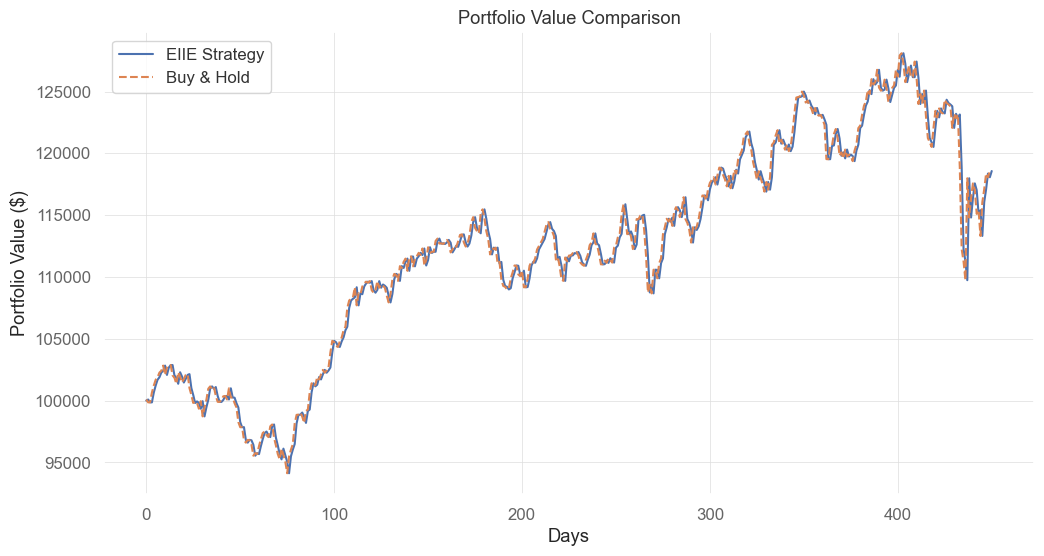

In [123]:
# Plot results
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(eiie_values, label="EIIE Strategy")
plt.plot(bh_values, label="Buy & Hold", linestyle="--")
plt.title("Portfolio Value Comparison")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()
plt.close()

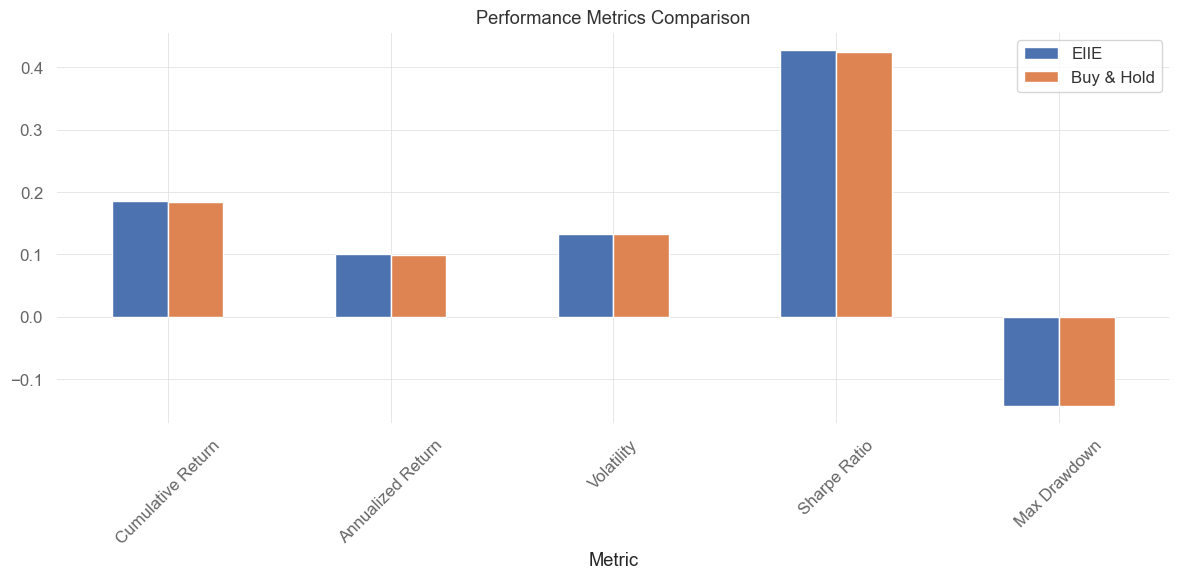

In [125]:
# plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
metrics_df.set_index("Metric").plot(kind="bar", ax=plt.gca())
plt.title("Performance Metrics Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

In [110]:
# Display metrics
print("\nPerformance Metrics:")
display(
    metrics_df.style.format(
        {
            "EIIE": "{:.2%}",
            "Buy & Hold": "{:.2%}",
            "Sharpe Ratio": "{:.2f}",
            "Volatility": "{:.2%}",
        }
    )
)


Performance Metrics:


,Metric,EIIE,Buy & Hold
0,Cumulative Return,18.57%,18.46%
1,Annualized Return,10.01%,9.95%
2,Volatility,13.33%,13.33%
3,Sharpe Ratio,42.84%,42.43%
4,Max Drawdown,-14.33%,-14.33%


In [111]:
# Additional Sharpe ratio optimization
log_returns = raw_df.pivot_table(index="date", columns="tic", values="close")
log_returns = np.log(log_returns.pct_change() + 1).dropna()
cov_matrix = log_returns.cov() * 252


def negative_sharpe(weights):
    port_return = np.dot(weights, log_returns.mean()) * 252
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(port_return - risk_free_rate) / port_vol


constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bounds = [(0, 1) for _ in tickers]
initial_weights = np.array([1 / len(tickers)] * len(tickers))

result = minimize(
    negative_sharpe,
    initial_weights,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

print("\nOptimal Weights from Sharpe Ratio Optimization:")
for ticker, weight in zip(tickers, result.x):
    print(f"{ticker}: {weight:.2%}")


Optimal Weights from Sharpe Ratio Optimization:
AXP: 34.19%
AMGN: 0.00%
AAPL: 0.00%
BA: 0.00%
CAT: 1.72%
CSCO: 0.00%
CVX: 0.00%
GS: 0.00%
HD: 0.00%
HON: 0.00%
IBM: 7.76%
INTC: 0.00%
JNJ: 0.00%
KO: 0.00%
JPM: 0.00%
MCD: 0.00%
MMM: 0.00%
MRK: 0.00%
MSFT: 0.00%
NKE: 0.00%
PG: 0.00%
TRV: 2.64%
UNH: 0.00%
CRM: 0.00%
VZ: 0.00%
V: 0.00%
WBA: 0.00%
WMT: 0.00%
DIS: 0.00%
DOW: 53.68%
